In [18]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE

In [20]:
#data load
df = pd.read_csv("HR_comma_sep.csv")

In [22]:
#check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64


In [24]:
#data type
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None


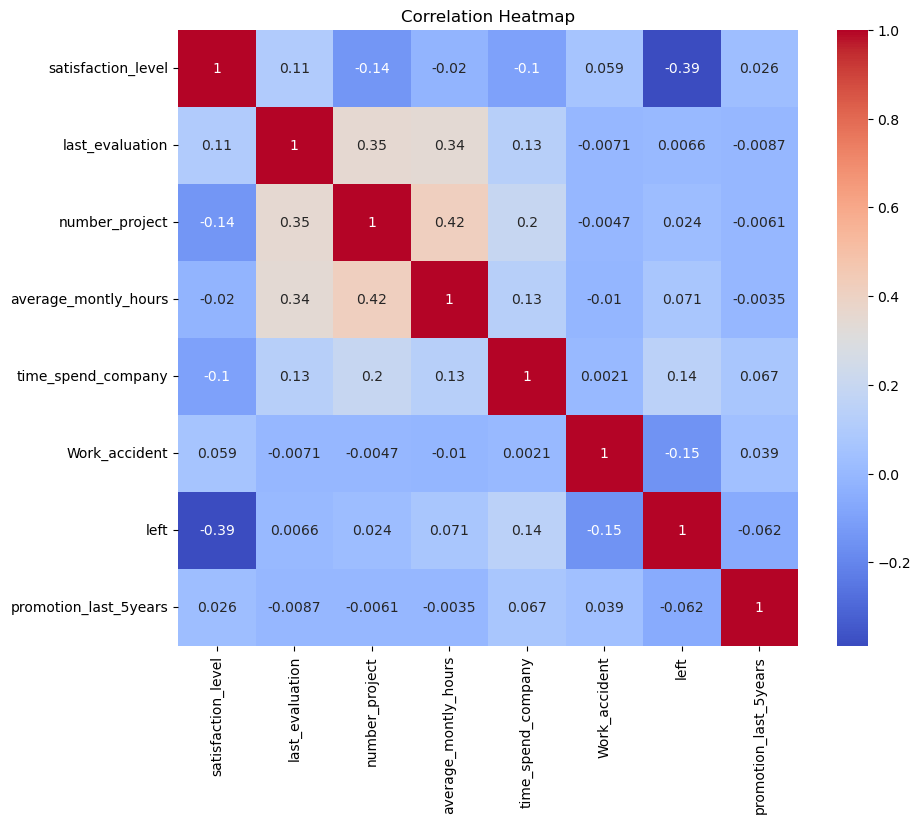

In [26]:
#exploratory data analysis
numerical_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

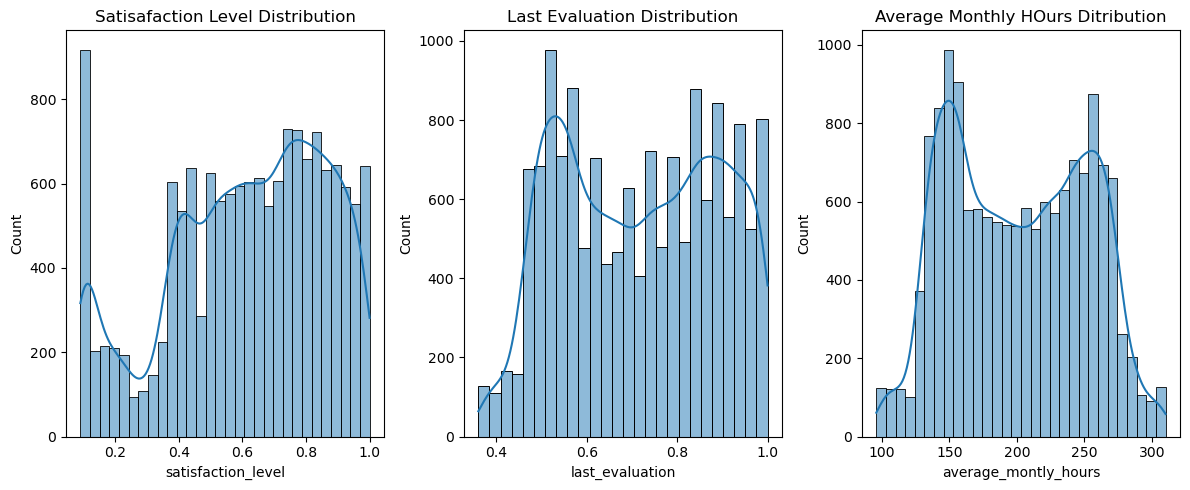

In [28]:
#distribution plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
sns.histplot(df["satisfaction_level"], kde=True)
plt.title("Satisafaction Level Distribution")

plt.subplot(1, 3, 2)
sns.histplot(df["last_evaluation"], kde=True)
plt.title("Last Evaluation Distribution")

plt.subplot(1, 3, 3)
sns.histplot(df["average_montly_hours"], kde=True)
plt.title("Average Monthly HOurs Ditribution")

plt.tight_layout()
plt.show()

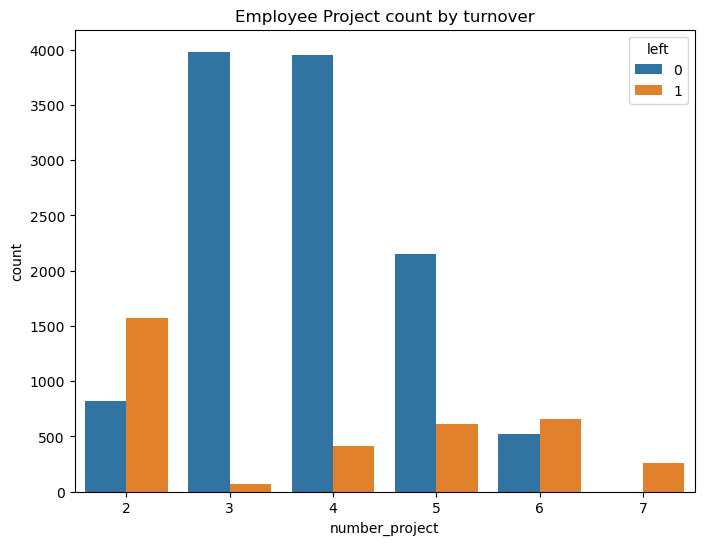

In [30]:
#bar plot of employee project count
plt.figure(figsize=(8, 6))
sns.countplot(x="number_project", hue="left", data=df)
plt.title("Employee Project count by turnover")
plt.show()

In [32]:
#clustering employes who left 
cluster_data = df[["satisfaction_level", "last_evaluation", "left"]]

In [34]:
#filter data for emplyess who left
left_employees = cluster_data[cluster_data["left"] == 1].copy()

In [36]:
#scale the data
scaler = StandardScaler()
left_employees_scaled = scaler.fit_transform(left_employees[["satisfaction_level", "last_evaluation"]])

In [44]:
#apply kmeands clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
left_employees["cluster"] = kmeans.fit_predict(left_employees_scaled)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(


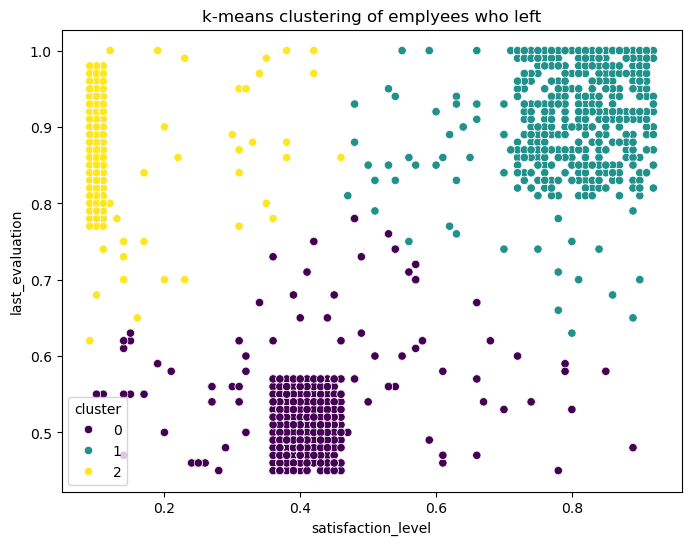

In [46]:
#visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x="satisfaction_level", y="last_evaluation", hue="cluster", data=left_employees,palette="viridis")
plt.title("k-means clustering of emplyees who left")
plt.show()

In [56]:
#analyze the clusters
print(left_employees.groupby("cluster")[["satisfaction_level", "last_evaluation"]].mean())

         satisfaction_level  last_evaluation
cluster                                     
0                  0.412304         0.517265
1                  0.808031         0.916415
2                  0.111321         0.870884


In [60]:
#handling class imbalance smote
##separate categorical and numerical columns
categorical_cols = df.select_dtypes(include=["object"]).columns
nmerical_cols = df.select_dtypes(include=np.number).columns

In [62]:
#apply get_deummies
categorical_dummies = pd.get_dummies(df[categorical_cols], drop_first=True)

In [64]:
#concatenate numerical and categorical columns
x = pd.concat([df[numerical_cols].drop("left", axis=1), categorical_dummies], axis=1)
y =df["left"]

In [70]:
#strainfied train_test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=123)

In [72]:
smote = SMOTE(random_state=123)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

print("Shape of x_train before SMOTE:", x_train.shape)
print("Shape of x_train afer SMOTE:", x_train_resampled.shape)
print("Shape of y_train before SMOTE:", y_train.shape)
print("Shape of y_train after SMOTE:", y_train_resampled.shape)

Shape of x_train before SMOTE: (11999, 18)
Shape of x_train afer SMOTE: (18284, 18)
Shape of y_train before SMOTE: (11999,)
Shape of y_train after SMOTE: (18284,)


In [92]:
#5-fold cross-validation model training and evaluation
logistic_model = LogisticRegression(solver="liblinear", random_state=123)
rf_model = RandomForestClassifier(random_state=123)
gb_model = GradientBoostingClassifier(random_state=123)

In [76]:
#set up k-fold cross-validation
kf= KFold(n_splits=5, shuffle=True, random_state=123)

In [86]:
#logistic regression
print("Logistic Regression:")
cv_scores_lr = cross_val_score(logistic_model, x_train_resampled, y_train_resampled, cv=kf, scoring='f1_weighted')
print("Cross-Validation F1 Scores:", cv_scores_lr)
print("Mean F1 Score:", cv_scores_lr.mean())

logistic_model.fit(x_train_resampled, y_train_resampled)
y_pred_lr = logistic_model.predict(x_test)
print(classification_report(y_test, y_pred_lr))

Logistic Regression:
Cross-Validation F1 Scores: [0.79073577 0.80473005 0.79516783 0.79055711 0.7907405 ]
Mean F1 Score: 0.7943862531640388
              precision    recall  f1-score   support

           0       0.91      0.77      0.83      2286
           1       0.51      0.74      0.60       714

    accuracy                           0.77      3000
   macro avg       0.71      0.76      0.72      3000
weighted avg       0.81      0.77      0.78      3000



In [98]:
#random forest classifier
print("\nRandom Forest Classifier:")
cv_scores_rf = cross_val_score(rf_model, x_train_resampled, y_train_resampled, cv=kf, scoring="f1_weighted")
print("Cross-Validation F1 Scores:", cv_scores_rf)
print("Mean F1 Score:", cv_scores_rf.mean())

rf_model.fit(x_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict(x_test)
print(classification_report(y_test, y_pred_rf))


Random Forest Classifier:
Cross-Validation F1 Scores: [0.98550708 0.98659979 0.98523121 0.98003731 0.98796317]
Mean F1 Score: 0.9850677140040848
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.98      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [102]:
#gradient boosting calssifier
print("\nGradient Boosting Classifier:")
cv_scores_gb = cross_val_score(gb_model, x_train_resampled, y_train_resampled, cv=kf, scoring='f1_weighted')
print("Cross-Validation F1 Scores:", cv_scores_gb)
print("Mean F1 Scores:", cv_scores_gb.mean())

gb_model.fit(x_train_resampled, y_train_resampled)
y_pred_gb = gb_model.predict(x_test)
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Classifier:
Cross-Validation F1 Scores: [0.96007194 0.96690439 0.96280145 0.95815991 0.9704562 ]
Mean F1 Scores: 0.9636787796237446
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2286
           1       0.92      0.93      0.92       714

    accuracy                           0.96      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.96      0.96      0.96      3000



In [106]:
#identify the best model and justify evaluatio metrics roc/auc
plt.figure(figsize=(8, 6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

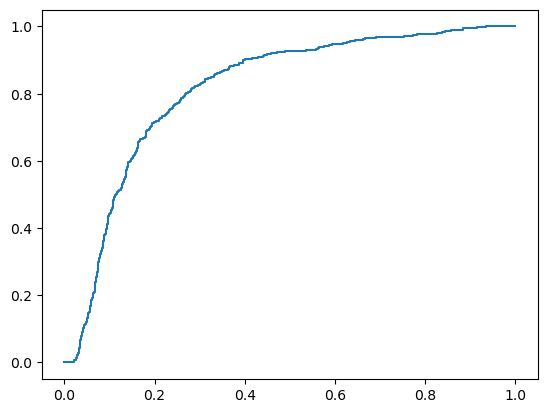

In [112]:
#logistic regression
logistic_model.fit(x_train_resampled, y_train_resampled)
y_pred_proba_lr = logistic_model.predict_proba(x_test)[:, 1]
fpr_lr, tpr_lr, _=roc_curve(y_test, y_pred_proba_lr)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f}")

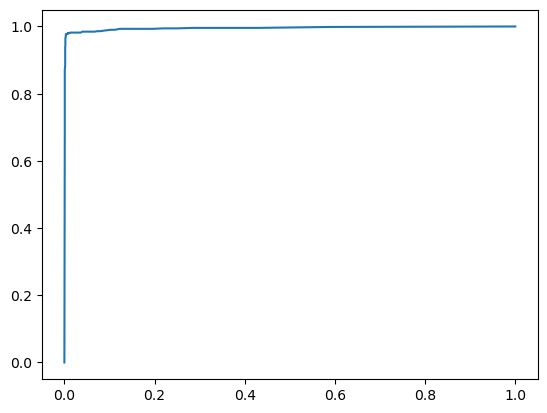

In [114]:
#random foret
rf_model.fit(x_train_resampled, y_train_resampled)
y_pred_proba_rf = rf_model.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, _=roc_curve(y_test, y_pred_proba_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_lr:.2f}")

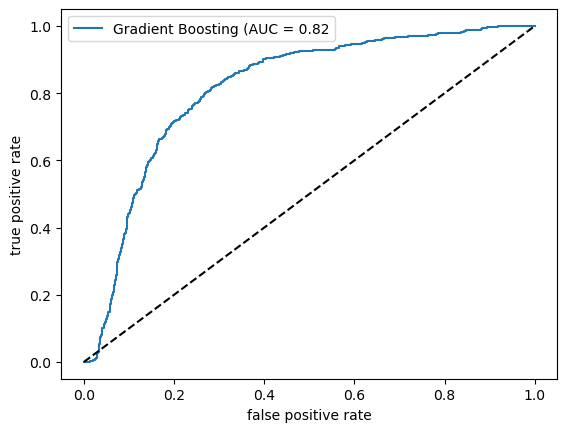

In [120]:
#gradient boosting
gb_model.fit(x_train_resampled, y_train_resampled)
y_pred_proba_gb = logistic_model.predict_proba(x_test)[:, 1]
fpr_gb, tpr_gb, _=roc_curve(y_test, y_pred_proba_gb)
auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {auc_lr:.2f}")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend()
plt.show()

In [122]:
#confusion matrices
print("\nConfusin Matrix - Logistic Regression:")
print(confusion_matrix(y_test, y_pred_lr))

print("\nConfusin Matrix - Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nConfusin Matrix - Gradient Boosting:")
print(confusion_matrix(y_test, y_pred_gb))


Confusin Matrix - Logistic Regression:
[[1768  518]
 [ 184  530]]

Confusin Matrix - Random Forest:
[[2272   14]
 [  16  698]]

Confusin Matrix - Gradient Boosting:
[[2228   58]
 [  50  664]]


#Recall vs. Precision
# In the context of employee turnover, Recall is more important than Precision.
# Recall (True Positive Rate) measures the ability of the model to correctly identify employees who will leave the company.
# It is crucial to minimize False Negatives (predicting that an employee will stay when they will actually leave) because the cost of failing to identify an employee who is about to leave is higher than the cost of falsely identifying an employee as likely to leave when they are not.

In [126]:
#retention strategies
#assuming gradient boosting performed the best
y_pred_proba = gb_model.predict_proba(x_test)[:, 1]

In [128]:
#create a dataframe for test data with predicted probabilities
test_results = x_test.copy()
test_results["predicted_probability"] = y_pred_proba

In [136]:
#categorire employeees and suggest retentin strategies
def categorire_emplotee(score):
    if score < 0.20:
        return "Safe Zone (Green)"
    elif 0.20 <= score < 0.60:
        return "Low-Rick Zone (Yellow)"
    elif 0.60 <= score <0.90:
        return "Medium-Risk Zone (Orange)"
    else:
        return "High-Rick Zone (Red)"

test_results["risk_zone"] = test_results["predicted_probability"].apply(categorire_emplotee)
print(test_results[["predicted_probability", "risk_zone"]].head())

       predicted_probability             risk_zone
10627               0.006081     Safe Zone (Green)
2703                0.951036  High-Rick Zone (Red)
6059                0.093995     Safe Zone (Green)
3258                0.017543     Safe Zone (Green)
4565                0.023761     Safe Zone (Green)


In [ ]:
#suggest retentin strategies example
for zone in test_results["risk_zone"].unique():
    print(f"\n--- {zone} ---")
    zone_data = test_results[test_results["risk_zone"] == zone]
    if zone == "High-Risk Zone (Red)":
        print("Retention Strategies:")
        print("- Immediate intervention wiht personalized retention plans.")
        print("- Review compensation and benefits.")
    elif zone == "Medium-Risk Zone (Orange)":
        print("Retention Strategies:")
        print("- Conduct regular check-ins to discuss concerns.")
        print("- Provide opportuinties for career advancement.")
        print("- Encourage a healthy work-life balance.")
    elif zone == "Low-Risk Zone (Yellow)":
        print("Retention Strategies:")
        print("- Maintain open communication and provide feedback.")
        print("- Recognize and reward good performance.")
    else:
        print("Retention Strategies:")
        print("- Continue to foster a positive work avniromnent.")
        print("- Offer opportunities for skill enhancement.")